In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, ConfusionMatrixDisplay, precision_score, recall_score, PrecisionRecallDisplay
import seaborn as sns
sns.set_theme()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import shap
import mlflow
from feature_engineering import feature_engineering
import matplotlib.pyplot as plt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [2]:
train_df, test_df = feature_engineering()

Columns (0,38,50) have mixed types.Specify dtype option on import or set low_memory=False.


at the end of the preprocessing stage the shape is  (238980, 90)   development
at the end of the preprocessing stage the shape is  (172016, 90)
wicket                0
Pitch X Bins          0
Pitch Y Bins          0
Ball Speed            0
At Stumps X Bins      1
At Stumps Y Bins      7
Over                  0
Movement In Air       0
Movement Off Pitch    0
MatchInnings          0
Bounce Angle          0
Match Id              0
Ball In Over          0
Power Play            0
dtype: int64


In [3]:
x_train_df = train_df.drop(columns=['wicket'])
x_test_df = test_df.drop(columns=['wicket'])

y_train_df = train_df['wicket']
y_test_df = test_df['wicket']

# Model Build

In [4]:
# Create dmatrix for XGBoost
dtrain = xgb.DMatrix(x_train_df.drop(columns=['Match Id', 'Ball In Over']), y_train_df, enable_categorical=True)
dtest = xgb.DMatrix(x_test_df.drop(columns=['Match Id', 'Ball In Over']), y_test_df, enable_categorical=True)

In [5]:
# Define hyperparameters
params = {
    'objective':'binary:logistic'
    , 'tree_method':'auto'
    , 'eval_metric':'aucpr'
    , 'eta':0.1
    , 'gamma':0.5
    , 'max_depth': 3
    , 'max_delta_step': 1
}

n = 1000

evals = [(dtrain, "train"), (dtest, "validation")]

## Hyperparameter Tuning

In [6]:
# def score(params):
#     print("Training with params: ")
#     print(params)
#     num_round = int(params['n_estimators'])
#     del params['n_estimators']
#     dtrain = xgb.DMatrix(x_train_df, y_train_df, enable_categorical=True)
#     dtest = xgb.DMatrix(x_test_df, y_test_df, enable_categorical=True)
#     watchlist = [(dtrain, 'train'), (dtest, 'eval')]
#     gbm_model = xgb.train(params, dtrain, num_round,
#                           evals=watchlist,
#                           verbose_eval=True,
#                           early_stopping_rounds=10)
#     predictions = gbm_model.predict(dtest,
#                                     )
#     score = roc_auc_score(y_test_df, predictions)
#     # TODO: Add the importance for the selected features
#     print("\tScore {0}\n\n".format(score))
#     # The score function should return the loss (1-score)
#     # since the optimize function looks for the minimum
#     loss = 1 - score
#     return {'loss': loss, 'status': STATUS_OK}

In [7]:
# def optimize(
#              #trials, 
#              random_state=123):
#     """
#     This is the optimization function that given a space (space here) of 
#     hyperparameters and a scoring function (score here), finds the best hyperparameters.
#     """
#     # To learn more about XGBoost parameters, head to this page: 
#     # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
#     space = {
#         'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
#         'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
#         # A problem with max_depth casted to float instead of int with
#         # the hp.quniform method.
#         'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
#         'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
#         'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
#         'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
#         'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#         'eval_metric': 'aucpr',
#         'objective': 'binary:logistic',
#         'tree_method':'exact'
#     }
#     # Use the fmin function from Hyperopt to find the best hyperparameters
#     best = fmin(score, space, algo=tpe.suggest, 
#                 # trials=trials, 
#                 max_evals=50)
#     return best

In [8]:
# best_hyperparams = optimize(
#                             #trials
#                             )
# print("The best hyperparameters are: ", "\n")
# print(best_hyperparams)

In [6]:
# Run Model
model = xgb.train(
    params=params
    , dtrain=dtrain
    , num_boost_round = n
    , verbose_eval=10
    , early_stopping_rounds=50
    , evals=evals
)

best_iteration = model.best_iteration
yhat = model.predict(dtest, iteration_range=(0, best_iteration))
predictions = [round(value) for value in yhat]
yhat_train = model.predict(dtrain, iteration_range=(0, best_iteration))
predictions_train = [round(value) for value in yhat_train]

[0]	train-aucpr:0.07765	validation-aucpr:0.07346
[10]	train-aucpr:0.08691	validation-aucpr:0.08182
[20]	train-aucpr:0.08994	validation-aucpr:0.08514
[30]	train-aucpr:0.09266	validation-aucpr:0.08808
[40]	train-aucpr:0.09575	validation-aucpr:0.09078
[50]	train-aucpr:0.09791	validation-aucpr:0.09208
[60]	train-aucpr:0.09987	validation-aucpr:0.09329
[70]	train-aucpr:0.10221	validation-aucpr:0.09457
[80]	train-aucpr:0.10455	validation-aucpr:0.09608
[90]	train-aucpr:0.10601	validation-aucpr:0.09702
[100]	train-aucpr:0.10807	validation-aucpr:0.09850
[110]	train-aucpr:0.10922	validation-aucpr:0.09885
[120]	train-aucpr:0.11036	validation-aucpr:0.09923
[130]	train-aucpr:0.11149	validation-aucpr:0.09959
[140]	train-aucpr:0.11226	validation-aucpr:0.09972
[150]	train-aucpr:0.11322	validation-aucpr:0.10043
[160]	train-aucpr:0.11512	validation-aucpr:0.10135
[170]	train-aucpr:0.11708	validation-aucpr:0.10247
[180]	train-aucpr:0.11785	validation-aucpr:0.10270
[190]	train-aucpr:0.11884	validation-aucpr

# Evaluation

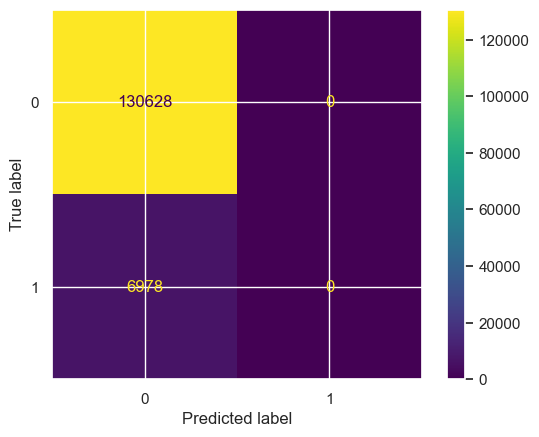

In [7]:
cm = confusion_matrix(y_train_df, predictions_train, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

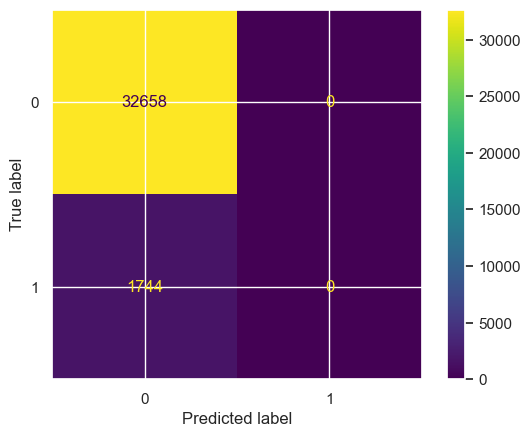

In [8]:
cm = confusion_matrix(y_test_df, predictions, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [9]:
y_test_df.sum()

1744

In [10]:
yhat.sum()

1750.3689

In [11]:
print(f'Mean: {yhat.mean()}\nSTD: {yhat.std()}\nMin: {yhat.min()}\nMax: {yhat.max()}')

Mean: 0.05087985843420029
STD: 0.030654696747660637
Min: 0.0028450910467654467
Max: 0.43935659527778625


Text(0.5, 0, 'xW')

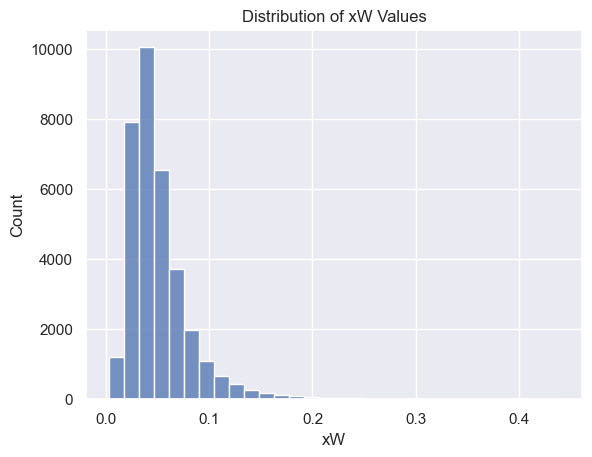

In [12]:
ax = sns.histplot(yhat, bins=30)
ax.set_title('Distribution of xW Values')
ax.set_xlabel('xW')

In [13]:
bins = list(np.arange(0,1.05,0.05))
bucketed = pd.cut(yhat, bins=bins)
bucket_counts = bucketed.value_counts().sort_index()
bucket_counts

(0.0, 0.05]    21099
(0.05, 0.1]    11076
(0.1, 0.15]     1690
(0.15, 0.2]      387
(0.2, 0.25]      115
(0.25, 0.3]       25
(0.3, 0.35]        7
(0.35, 0.4]        2
(0.4, 0.45]        1
(0.45, 0.5]        0
(0.5, 0.55]        0
(0.55, 0.6]        0
(0.6, 0.65]        0
(0.65, 0.7]        0
(0.7, 0.75]        0
(0.75, 0.8]        0
(0.8, 0.85]        0
(0.85, 0.9]        0
(0.9, 0.95]        0
(0.95, 1.0]        0
dtype: int64

## SHAP

In [14]:
X = pd.concat([x_train_df.drop(columns=['Match Id', 'Ball In Over']),x_test_df.drop(columns=['Match Id', 'Ball In Over'])])

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [17]:
# explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [18]:
shap.initjs()

In [19]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

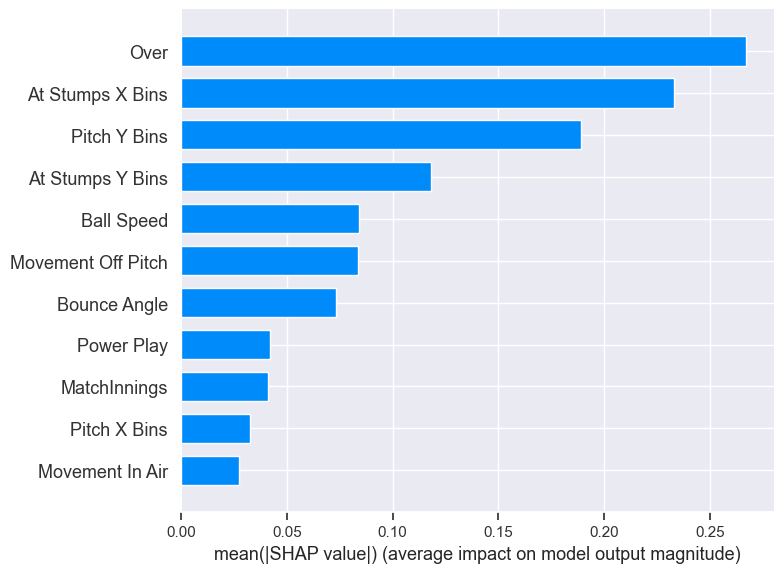

In [20]:
shap.summary_plot(shap_values, X, plot_type="bar")

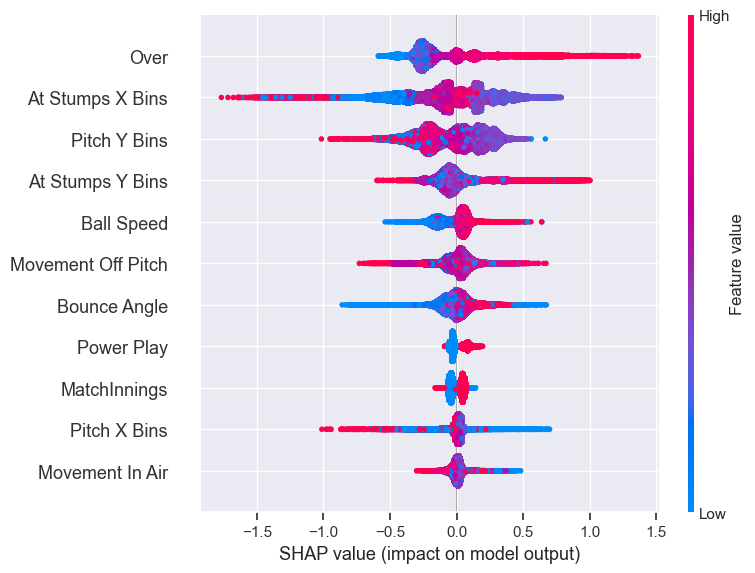

In [21]:
shap.summary_plot(shap_values, X)

## Analysis

In [22]:
df = feature_engineering('Predict')

Columns (0,38,50) have mixed types.Specify dtype option on import or set low_memory=False.


at the end of the preprocessing stage the shape is  (238980, 90)   Predict
at the end of the preprocessing stage the shape is  (238980, 90)
wicket                    0
Pitch X Bins             32
Pitch Y Bins          47527
Ball Speed            36103
At Stumps X Bins         20
At Stumps Y Bins      37860
Over                      0
Movement In Air       49296
Movement Off Pitch    49428
MatchInnings              0
Bounce Angle          53714
Match Id                  0
Ball In Over              0
Power Play                0
dtype: int64


# Model Build

In [23]:
# Create dmatrix for XGBoost
dpredict = xgb.DMatrix(df.drop(columns=['Match Id', 'Ball In Over','wicket']), df['wicket'], enable_categorical=True)

In [24]:
yhat = model.predict(dpredict, iteration_range=(0, best_iteration))

In [25]:
df['xw'] = yhat

In [26]:
df.shape

(181705, 15)

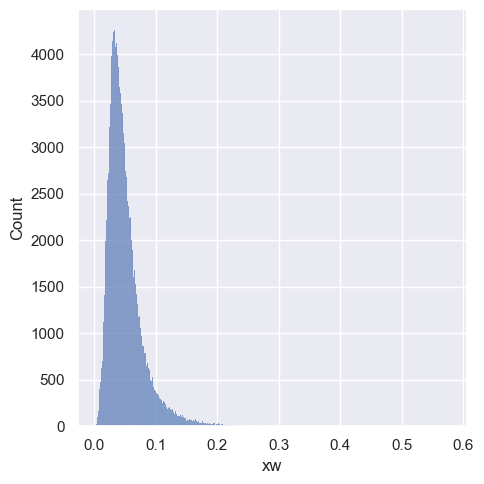

In [27]:
sns.displot(df['xw'])

In [28]:
df_actual = pd.read_csv(r'C:\Users\anude\Desktop\Jupyter Notebook Projects\Cricket NSW\Data\T20M BBB - latest.csv')

Columns (0,38,50) have mixed types.Specify dtype option on import or set low_memory=False.


In [29]:
cols = list(set(df_actual.columns)-set(df.columns))
cols.append('Match Id')
cols.append('MatchInnings')
cols.append('Over')
cols.append('Ball In Over')

In [30]:
df = df.merge(df_actual[cols],on=['Match Id', 'MatchInnings', 'Over', 'Ball In Over'],how='inner')

In [31]:
df.to_csv('xw_output.csv',index=False)

In [17]:
pred_df.drop(columns=['Impact Location'],inplace=True)

NameError: name 'pred_df' is not defined

In [196]:
pred_df.loc[
(pred_df['At Stumps X']>1100)
, 'Impact Location'
] = 'Off Side Wide'

pred_df.loc[
(pred_df['At Stumps Y'] <= 720)
& (pred_df['At Stumps X']>=-115)
& (pred_df['At Stumps X']<=115)
, 'Impact Location'
] = 'Stumps'

pred_df.loc[
(pred_df['At Stumps Y'] <= 150)
& (pred_df['At Stumps X']>=-115)
& (pred_df['At Stumps X']<=115)
, 'Impact Location'
] = 'Yorker, Stumps'

pred_df.loc[
(pred_df['At Stumps Y Bins'] >= 16)
& (pred_df['At Stumps X']>=-115)
& (pred_df['At Stumps X']<=115)
, 'Impact Location'
] = 'Bouncer, Stumps'

pred_df.loc[
(pred_df['At Stumps Y'] <= 150)
& (pred_df['At Stumps X']>=115)
& (pred_df['At Stumps X']<=1100)
, 'Impact Location'
] = 'Yorker, Outside Off Stump'

pred_df.loc[
(pred_df['At Stumps Y Bins'] >= 16)
& (pred_df['At Stumps X']>=115)
& (pred_df['At Stumps X']<=1100)
, 'Impact Location'
] = 'Bouncer, Wide'

In [197]:
pred_df['Impact Location'].value_counts()

Stumps                       19244
Yorker, Outside Off Stump     2133
Off Side Wide                 2007
Bouncer, Wide                 1425
Yorker, Stumps                 921
Bouncer, Stumps                697
Name: Impact Location, dtype: int64

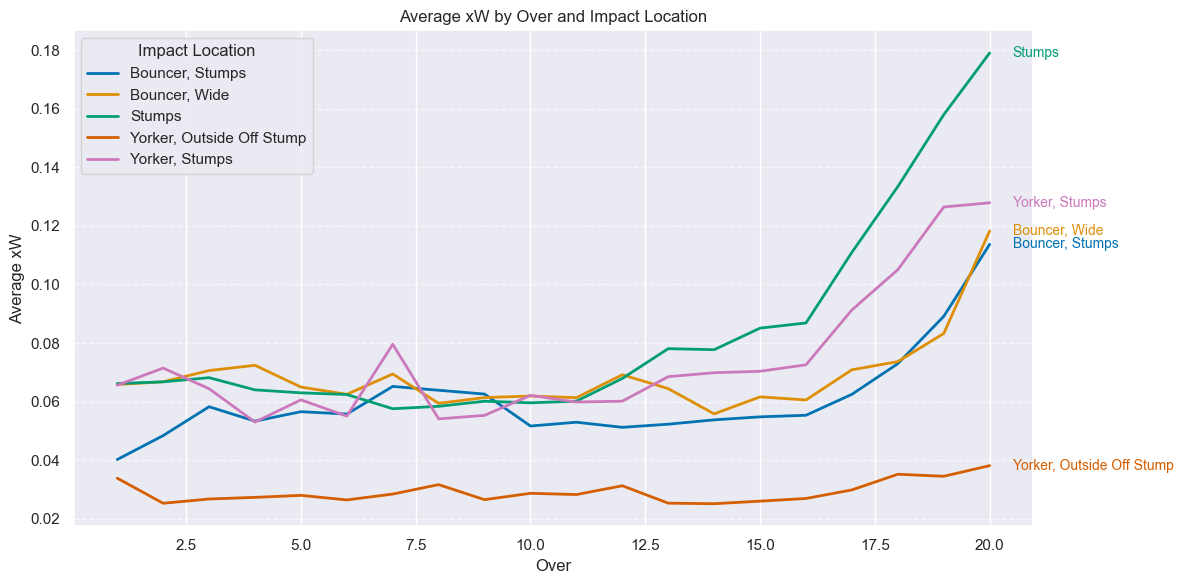

In [212]:
# Group the data by 'Over' and 'Impact Location', and calculate the mean xw
grouped_df = pred_df.loc[~pred_df['Impact Location'].isin(['Off Side Wide'])].groupby(['Over', 'Impact Location']).agg({'xw': 'mean'}).reset_index()

# Create the line plot using the colorblind palette
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_df,
    x='Over',
    y='xw',
    hue='Impact Location',
    palette='colorblind',
    linewidth=2
)

# Add labels and title
plt.xlabel("Over")
plt.ylabel("Average xW")
plt.title("Average xW by Over and Impact Location")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Label each line at its endpoint
for impact_location, data in grouped_df.groupby("Impact Location"):
    # Find the last point for each line
    last_over = data["Over"].max()
    last_xw = data[data["Over"] == last_over]["xw"].values[0]
    plt.text(
        x=last_over + 0.5,  # Offset to the right
        y=last_xw,
        s=impact_location,  # Use Impact Location as the label
        color=sns.color_palette("colorblind")[grouped_df["Impact Location"].unique().tolist().index(impact_location)],
        fontsize=10,
        va="center"
    )

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [177]:
pred_df.loc[pred_df['Impact Location'].isnull()].shape

(37338, 72)

Text(0, 0.5, 'Average xW')

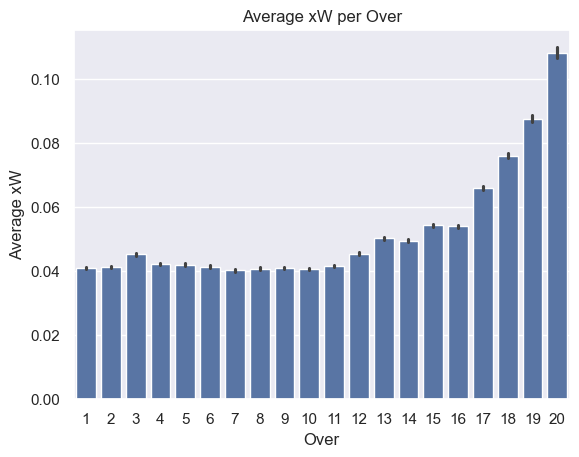

In [120]:
ax = sns.barplot(pred_df.loc[pred_df['MatchInnings']<=2],x='Over',y='xw')
ax.set_title('Average xW per Over')
ax.set_ylabel('Average xW')

<Axes: xlabel='wicket', ylabel='xw'>

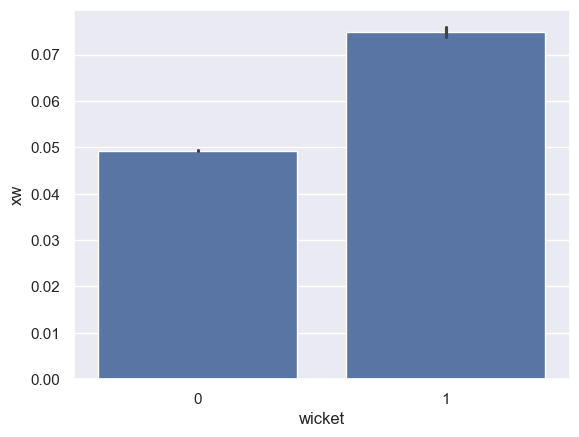

In [29]:
sns.barplot(pred_df,x='wicket',y='xw')

Text(0.5, 0, 'xW')

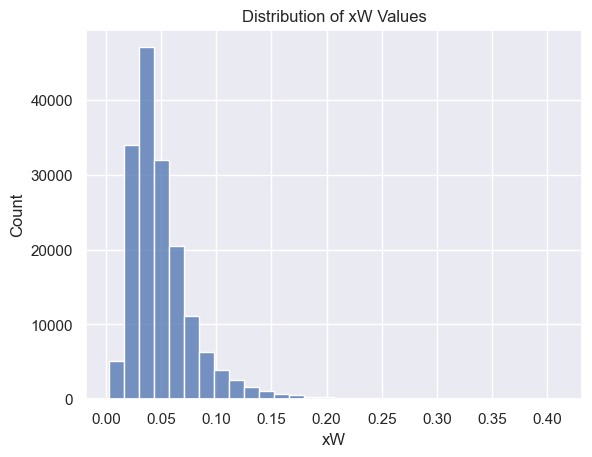

In [31]:
ax = sns.histplot(pred_df['xw'], bins=30)
ax.set_title('Distribution of xW Values')
ax.set_xlabel('xW')

In [32]:
print(f"Mean: {pred_df['xw'].mean()}\nSTD: {pred_df['xw'].std()}\nMin: {pred_df['xw'].min()}\nMax: {pred_df['xw'].max()}")

Mean: 0.050616685301065445
STD: 0.03105262480676174
Min: 0.002627067267894745
Max: 0.4112744629383087


In [33]:
pred_df['xw_mean_adjusted'] = pred_df['xw']/0.05

Text(0.5, 0, 'xW')

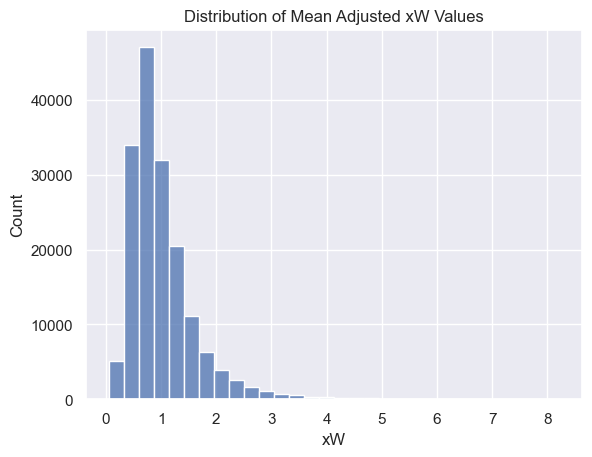

In [34]:
ax = sns.histplot(pred_df['xw_mean_adjusted'], bins=30)
ax.set_title('Distribution of Mean Adjusted xW Values')
ax.set_xlabel('xW')

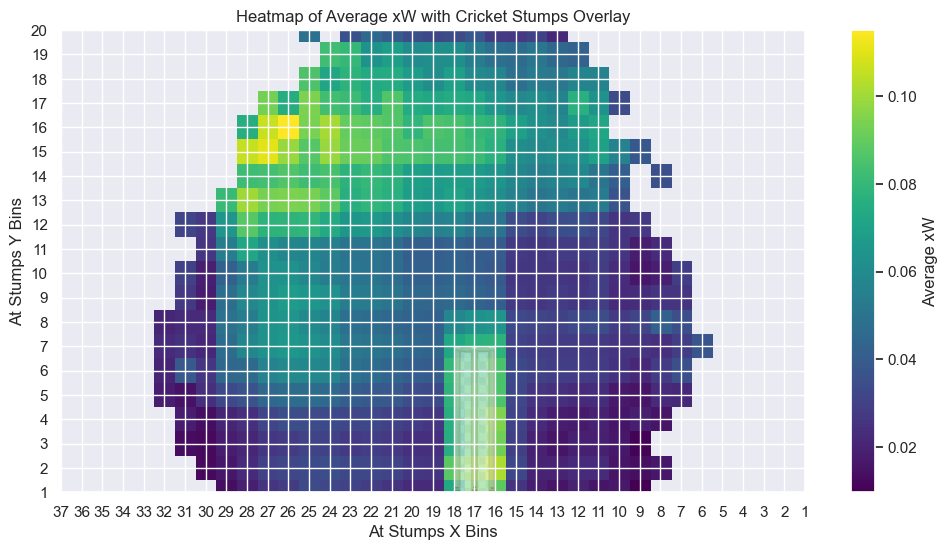

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Group by bins and calculate average Runs Scored
grouped_df = pred_df.groupby(["At Stumps X Bins", "At Stumps Y Bins"]).agg({'xw':'mean','Over':'count'}).reset_index()

grouped_df.loc[grouped_df['Over']<=10,'xw'] = np.nan

# Pivot to create a heatmap-ready format
heatmap_data = grouped_df.pivot(
    index="At Stumps Y Bins", 
    columns="At Stumps X Bins", 
    values="xw"
)

# Load the stumps image
stumps_image_path = r"C:\Users\anude\Desktop\Jupyter Notebook Projects\Cricket NSW\Data\stumps.png" # Replace with your stumps image path
stumps_image = Image.open(stumps_image_path)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 6))
heatmap = ax.imshow(
    heatmap_data, 
    cmap="viridis", 
    origin="lower", 
    extent=[0.5, heatmap_data.shape[1] + 0.5, 0.5, heatmap_data.shape[0] + 0.5]
)

# Add colorbar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label("Average xW")

# Overlay the stumps image
# Adjust the position and size of the stumps
stumps_extent = [16, 18, 1, 7]  # [x_min, x_max, y_min, y_max]
ax.imshow(stumps_image, aspect="auto", extent=stumps_extent, alpha=0.55)

# Reverse the X-axis
ax.invert_xaxis()

# Add labels and titles
ax.set_title("Heatmap of Average xW with Cricket Stumps Overlay")
ax.set_xlabel("At Stumps X Bins")
ax.set_ylabel("At Stumps Y Bins")

# Customize ticks
ax.set_xticks(range(1, heatmap_data.shape[1] + 1))
ax.set_yticks(range(1, heatmap_data.shape[0] + 1))

plt.show()


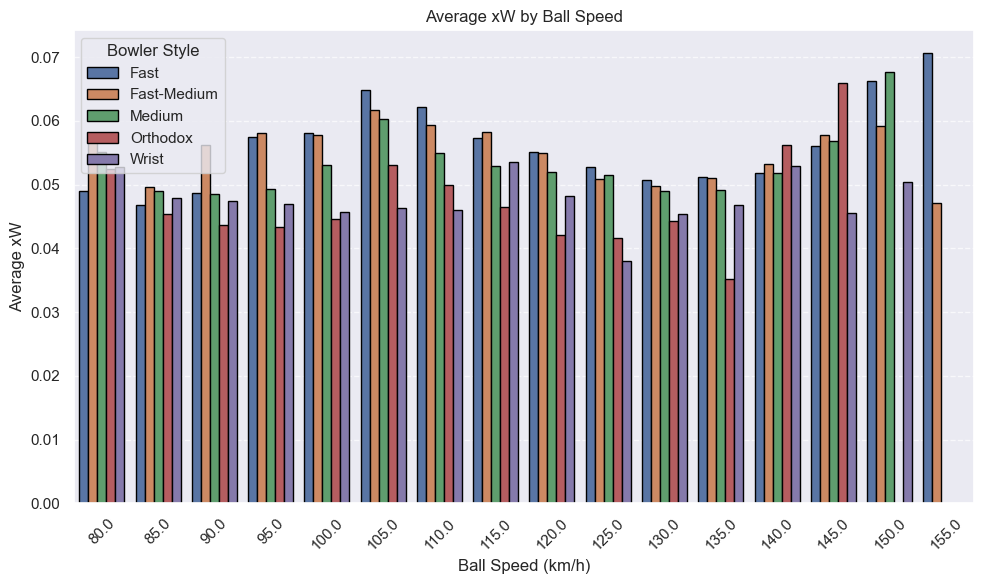

In [130]:
# Define the bin edges for Ball Speed (5 km/h intervals)
bin_edges = np.arange(pred_df["Ball Speed"].min() // 5 * 5, pred_df["Ball Speed"].max() + 5, 5)

# Create bins for Ball Speed
pred_df["Speed Bins"] = pd.cut(pred_df["Ball Speed"], bins=bin_edges, right=False, labels=bin_edges[:-1])

# Group by Speed Bins and calculate average xW
speed_bins_df = pred_df.groupby(["Speed Bins", 'Bowler Style']).agg(
    avg_xw=("xw", "mean"),
    count=("xw", "count")
).reset_index()


# Plot the average xW by Speed Bins
plt.figure(figsize=(10, 6))
sns.barplot(speed_bins_df, x="Speed Bins", y="avg_xw", hue='Bowler Style', edgecolor="black")
plt.xlabel("Ball Speed (km/h)")
plt.ylabel("Average xW")
plt.title("Average xW by Ball Speed")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [34]:
bowler_df = pred_df\
                .loc[
                    (pred_df['Series'] == 'Aus Domestic T20 M')
                    & (pred_df['Season']=='2023-24')
                ]\
                .groupby(
                    ['Bowler']
                )\
                .agg(
                    {
                        "wicket":"sum"
                        ,"xw":"sum"
                        ,'Over':'count'
                    }
                )\
                .rename(
                    columns = {
                        'Over':'Deliveries Bowled'
                    }
                )\
                .reset_index()

bowler_df['wicket/xw'] = bowler_df['wicket']/bowler_df['xw']

In [35]:
bowler_df\
.loc[bowler_df['Deliveries Bowled']>100]\
.sort_values(by='wicket/xw')

,Bowler,wicket,xw,Deliveries Bowled,wicket/xw
24,"Green, Christopher",3,6.508441,176,0.460940
63,"Short, Matthew",4,6.365981,135,0.628340
39,"McAndrew, Nathan",5,7.832350,151,0.638378
1,"Agar, Ashton",5,7.822164,157,0.639209
19,"Dooley, Patrick",6,9.269488,187,0.647285
79,"Zampa, Adam",5,7.360736,139,0.679280
51,"Paris, Joel",5,7.160395,130,0.698286
55,"Richardson, Jhye",6,8.503882,133,0.705560
34,"Kuhnemann, Matthew",6,8.194832,162,0.732169
30,"Jordan, Chris",9,10.901531,212,0.825572


In [36]:
batter_df = pred_df\
                .groupby(
                    ['Striker']
                )\
                .agg(
                    {
                        "wicket":"sum"
                        ,"xw":"sum"
                        ,'Over':'count'
                    }
                )\
                .rename(
                    columns = {
                        'Over':'Deliveries Faced'
                    }
                )\
                .reset_index()

batter_df['wicket/xw'] = batter_df['wicket']/batter_df['xw']

In [37]:
batter_df\
.loc[batter_df['Deliveries Faced']>100]\
.sort_values(by='wicket/xw', ascending=False)

,Striker,wicket,xw,Deliveries Faced,wicket/xw
201,"Dickwella, Niroshan",15,7.605256,177,1.972320
557,"Narine, Sunil",30,15.233294,344,1.969370
704,"Sarkar, Soumya",18,9.184878,203,1.959743
240,"Fernando, Avishka",14,7.146242,157,1.959072
276,"Gunathilaka, Danushka",21,11.384483,253,1.844616
343,"Jacks, Will",25,13.578238,320,1.841181
817,"Taylor, Steven Ryan",8,4.418988,102,1.810369
697,"Samson, Sanju Viswanath",14,8.027501,188,1.744005
731,"Sharma, Abhishek",18,10.391239,289,1.732228
63,"Ayub, Saim",12,6.957237,181,1.724823


<Axes: xlabel='Deliveries Faced', ylabel='xw'>

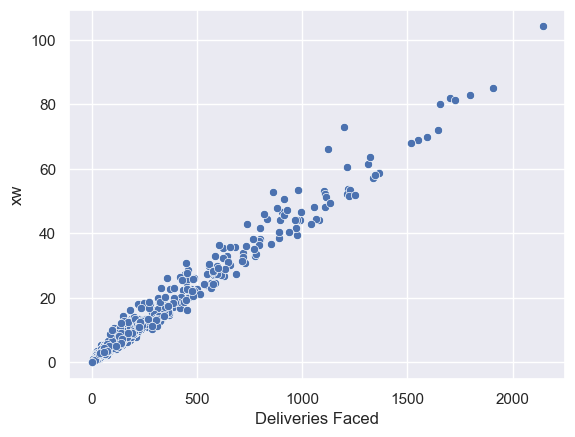

In [38]:
sns.scatterplot(batter_df,x='Deliveries Faced',y='xw')

<Axes: xlabel='Deliveries Faced', ylabel='wicket'>

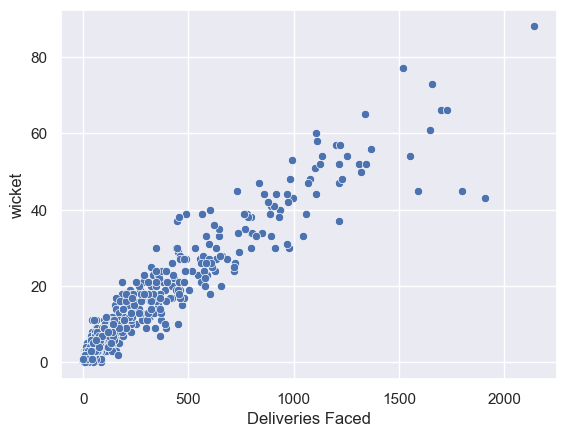

In [39]:
sns.scatterplot(batter_df,x='Deliveries Faced',y='wicket')

In [40]:
pred_df.loc[pred_df['Bowler']=='Starc, Mitchell'][['xw','wicket']].sum()

xw        50.198448
wicket    47.000000
dtype: float64